# Striplog with a binary 'flag'

We will invent a binary log -- maybe you can load it from an LAS file with `welly`.

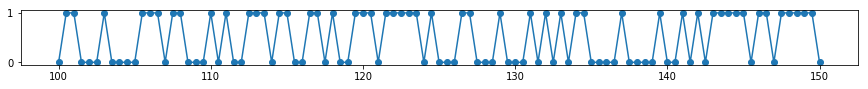

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

fake_depth = np.linspace(100, 150, 101)
fake_log = np.array([np.random.choice([0, 1]) for _ in fake_depth])

plt.figure(figsize=(15, 1))
plt.plot(fake_depth, fake_log, 'o-')

## Make a striplog

A `Striplog` is a sequence of `Interval` objects (representing a layer). Each `Interval` must contain a `Component` (representing the layer, perhaps a rock).

In [2]:
from striplog import Striplog, Component

In [3]:
comps = [
    Component({'pay': True}),
    Component({'pay': False})
]

In [4]:
s = Striplog.from_log(fake_log, cutoff=0.5, components=comps, basis=fake_depth)

In [5]:
s[-1].base.middle = 150.5 # Adjust the bottom thickness... not sure if this is a bug.

Each `Interval` in the striplog looks like:

In [6]:
s[0]

Interval({'top': Position({'middle': 100.0, 'units': 'm'}), 'base': Position({'middle': 100.5, 'units': 'm'}), 'description': '', 'data': {}, 'components': [Component({'pay': True})]})

## Plot the intervals

To plot we need a legend, but we can generate a random one. This maps each `Component` to a colour (and a width and hatch, if you want).

We can generate a random legend:

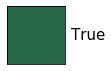

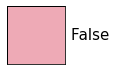

In [7]:
from striplog import Legend

legend = Legend.random(comps)
legend.get_decor(comps[-1]).width = 0.2
legend.plot()

Or we can make one with a bit more control:

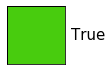

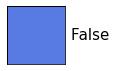

In [8]:

legend_csv = """colour,hatch,width,component pay
#48cc0e,None,1,True
#5779e2,None,0.2,False"""

legend = Legend.from_csv(text=legend_csv)

legend.plot()

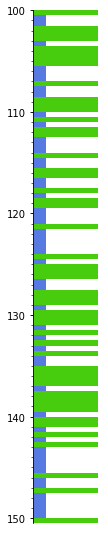

In [9]:
s.plot(legend=legend, aspect=5)

## Remove thin things

We can remove thin intervals:

In [10]:
pruned = s.prune(limit=1.0, keep_ends=True)

Now we can anneal the gaps:

In [11]:
annealed = pruned.anneal()

Then merge the adjacent intervals that are alike...

In [12]:
merged = annealed.merge_neighbours()  # Anneal works on a copy

We could have chained these commands:

    merged = s.prune(limit=1.0, keep_ends=True).anneal().merge_neighbours()

Let's plot all these steps, just for illustration:

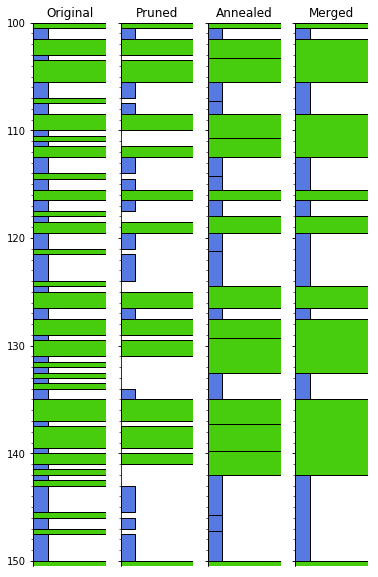

In [13]:
fig, axs = plt.subplots(ncols=4, figsize=(6, 10))

axs[0] = s.plot(legend=legend, ax=axs[0], lw=1, aspect=5)
axs[0].set_title('Original')
axs[1] = pruned.plot(legend=legend, ax=axs[1], lw=1, aspect=5)
axs[1].set_yticklabels([])
axs[1].set_title('Pruned')
axs[2] = annealed.plot(legend=legend, ax=axs[2], lw=1, aspect=5)
axs[2].set_yticklabels([])
axs[2].set_title('Annealed')
axs[3] = merged.plot(legend=legend, ax=axs[3], lw=1, aspect=5)
axs[3].set_yticklabels([])
axs[3].set_title('Merged')
plt.show()

## Dilate and erode

This would be a binary thing. Not implemented yet. I made an issue for this: https://github.com/agile-geoscience/striplog/issues/95

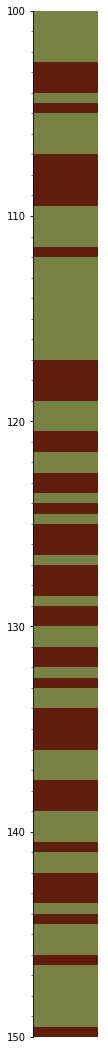

In [14]:
from striplog import Striplog, Component
import numpy as np
%matplotlib inline

fake_depth = np.linspace(100, 150, 101)
fake_log = np.array([np.random.choice([0, 1]) for _ in fake_depth])

comps = [
    Component({'pay': True}),  # Change value to 'pay'
    Component({'pay': False})  # Change value to 'non-pay'
]
s = Striplog.from_log(fake_log, cutoff=0.5, components=comps, basis=fake_depth)
s.plot()

In [15]:
csv_text = u"""colour, width, component lithology, component colour, component grainsize
#F7E9A6, 3, Sandstone, Grey, VF-F
#FF99CC, 2, Anhydrite, ,
#DBD6BC, 3, Heterolithic, Grey,
#FF4C4A, 2, Volcanic, ,
#86F0B6, 5, Conglomerate, ,
#FFD073, 4, Sandstone, Red, C-M
#A6D1FF, 3, Limestone, ,
#FFDBBA, 3, Sandstone, Red, VF-F"""


r = {'colour': 'grey',
     'grainsize': 'vf-f',
     'lithology': 'sand'}

r3 = {'colour': 'red',
      'grainsize': 'vf-f',
      'lithology': 'sandstone'}



In [18]:
from striplog import Decor

legend = Legend.from_csv(text=csv_text)
assert legend[0].colour == '#f7e9a6'
assert legend.max_width == 5
assert legend.__str__() != ''
assert legend.__repr__() != ''

assert len(legend[[3, 4]]) == 2
assert len(legend[3:5]) == 2

rock = Component(r)
assert legend.get_colour(rock) == '#eeeeee'
assert rock not in legend

d = Decor({'colour': 'red',
           'component': rock})
length = len(legend)
legend[3] = d
assert len(legend) == length
assert legend[3].component == rock
assert d in legend

rock3 = Component(r3)
assert legend.get_colour(rock3) == '#ffdbba'
assert legend.get_width(rock3) == 3.0

c = legend.get_component('#f7e9a6')
assert c.lithology == 'sandstone'
c2 = legend.get_component('#f7e9a7', tolerance=30)
assert c2.lithology == 'sandstone'

colours = [d.colour for d in legend]
assert len(colours) == 8

assert Legend.random(rock3)[0].colour != ''

l = Legend.random([rock, rock3])
assert len(l) == 2
assert getattr(l[-1], 'colour') != ''
assert l.to_csv() != ''
assert l.max_width == 0


AssertionError: 

In [20]:
l

Legend(Decor({'_colour': '#75feb7', 'component': Component({'colour': 'grey', 'grainsize': 'vf-f', 'lithology': 'sand'}), 'width': 1.0, 'hatch': None})
Decor({'_colour': '#54c2b5', 'component': Component({'colour': 'red', 'grainsize': 'vf-f', 'lithology': 'sandstone'}), 'width': 1.0, 'hatch': None}))

## Some statistics

We can get the unique components and their thicknesses:

In [15]:
s.unique

[(Component({'pay': 'non-pay'}), 25.5), (Component({'pay': 'pay'}), 25.0)]

We can get at the thickest (and thinnest, with `.thinnest()`) intervals:

In [16]:
s.thickest()

Interval({'top': Position({'middle': 104.0, 'units': 'm'}), 'base': Position({'middle': 108.0, 'units': 'm'}), 'description': '', 'data': {}, 'components': [Component({'pay': 'pay'})]})

These functions optionally take an integer argument `n` specifying how many of the thickest or thinnest intervals you want to see. If `n` is greater than 1, a `Striplog` object is returned so you can see the positions of those items:

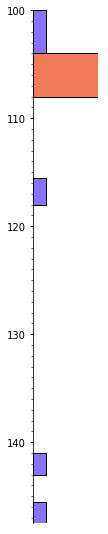

In [17]:
s.thickest(5).plot(legend=legend, lw=1, aspect=5)

## Bar plots and histograms

We can make a bar plot of the layers:

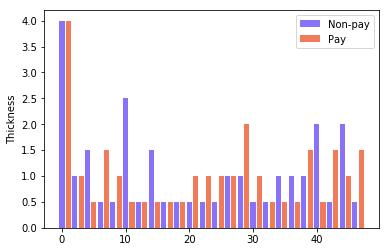

In [18]:
s.bar(legend=legend)

More interesting is to sort the thicknesses:

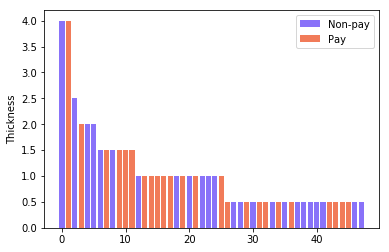

In [19]:
s.bar(legend=legend, sort=True)

Finally, we can make a thickness histogram of the various types of `component` present in the log.

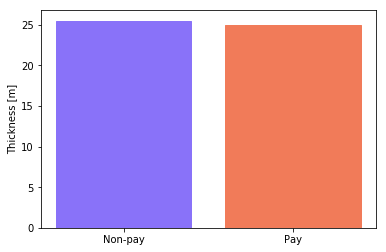

In [27]:
n, ents, ax = s.hist(legend=legend)